In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv', usecols = ['userId', 'movieId', 'rating'])
tags = pd.read_csv('ml-latest-small/tags.csv', usecols = ['userId', 'movieId', 'tag'])
links = pd.read_csv('ml-latest-small/links.csv')

In [3]:
g = {i:lambda x: '|'.join(list(x)) for i in tags.columns[2:]}
tags = tags.groupby(['userId', 'movieId']).agg(g).reset_index()
movies = pd.merge(movies, links, on=['movieId'])
reviews = pd.merge(ratings, tags, on=['userId', 'movieId'])

In [4]:
print("Movies head:\n", movies.head())
print("Reviews head:\n", reviews.head())

Movies head:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  imdbId   tmdbId  
0  Adventure|Animation|Children|Comedy|Fantasy  114709    862.0  
1                   Adventure|Children|Fantasy  113497   8844.0  
2                               Comedy|Romance  113228  15602.0  
3                         Comedy|Drama|Romance  114885  31357.0  
4                                       Comedy  113041  11862.0  
Reviews head:
    userId  movieId  rating                                      tag
0       2    60756     5.0       funny|Highly quotable|will ferrell
1       2    89774     5.0               Boxing story|MMA|Tom Hardy
2       2   106782     5.0  drugs|Leonardo DiCaprio|Martin Scorsese
3 

In [5]:
movies_info = (movies.shape[1], movies.shape[0])
ratings_info = (ratings.shape[1], ratings.shape[0])
tags_info = (tags.shape[1], tags.shape[0])
links_info = (links.shape[1], links.shape[0])

print(f"Movies: {movies_info[1]} records, {movies_info[0]} attributes")
print(f"Ratings: {ratings_info[1]} records, {ratings_info[0]} attributes")
print(f"Tags: {tags_info[1]} records, {tags_info[0]} attributes")
print(f"Links: {links_info[1]} records, {links_info[0]} attributes")

Movies: 9742 records, 5 attributes
Ratings: 100836 records, 3 attributes
Tags: 1775 records, 3 attributes
Links: 9742 records, 3 attributes


Text(0, 0.5, 'Count')

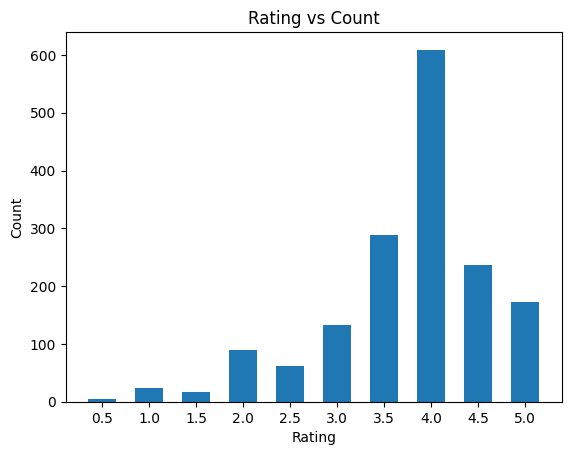

In [6]:
ratings_df = reviews.groupby(by=['rating']).agg({'userId': 'count'}).rename(columns={'userId': 'count'}).reset_index()
plt.bar(ratings_df['rating'], ratings_df['count'], align='center', width=0.3)
plt.xticks(ratings_df['rating'])
plt.title("Rating vs Count")
plt.xlabel("Rating")
plt.ylabel("Count")

In [7]:
display(movies)

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0
9739,193585,Flint (2017),Drama,6397426,479308.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0


In [8]:
vectorizer = TfidfVectorizer()
tag_matrix = vectorizer.fit_transform(reviews['tag'].fillna(''))

X = tag_matrix.toarray()
y = reviews['rating']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(),
    'LinearRegression': LinearRegression()
}

In [11]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}
    print(f'{name} - MSE: {mse}, R²: {r2}')

DecisionTree - MSE: 0.8924124626675977, R²: -0.3610624973518026
RandomForest - MSE: 0.675945390576441, R²: -0.03091783212141208
GradientBoosting - MSE: 0.6150980579422682, R²: 0.06188345201205525
LinearRegression - MSE: 4.785321835641905e+27, R²: -7.298331613144298e+27


In [12]:
model = models['RandomForest']

In [13]:
def prepare_features(new_movie_tags, tfidf):
    tag_features = tfidf.transform([new_movie_tags]).toarray()
    return tag_features

In [14]:
new_movie_tags = ["action packed, thrilling", "romantic, comedy", "suspenseful, mysterious"]
new_movie_features = [prepare_features(tags, vectorizer) for tags in new_movie_tags]

In [15]:
for tags, features in zip(new_movie_tags, new_movie_features):
    predicted_rating = model.predict(features)
    print(f'Predicted Rating for "{tags}": {predicted_rating[0]}')

Predicted Rating for "action packed, thrilling": 4.31925
Predicted Rating for "romantic, comedy": 3.5075
Predicted Rating for "suspenseful, mysterious": 3.98575


In [16]:
new_movie_features_array = np.vstack(new_movie_features)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(new_movie_features_array, check_additivity=False)

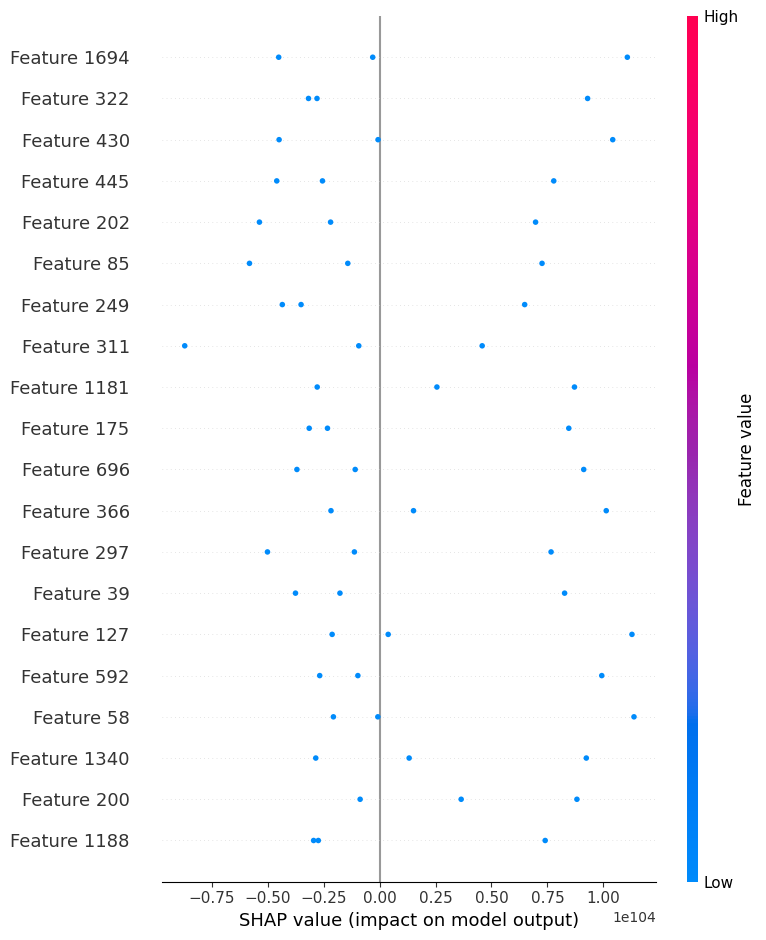

In [17]:
shap.summary_plot(shap_values, new_movie_features_array)

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0])